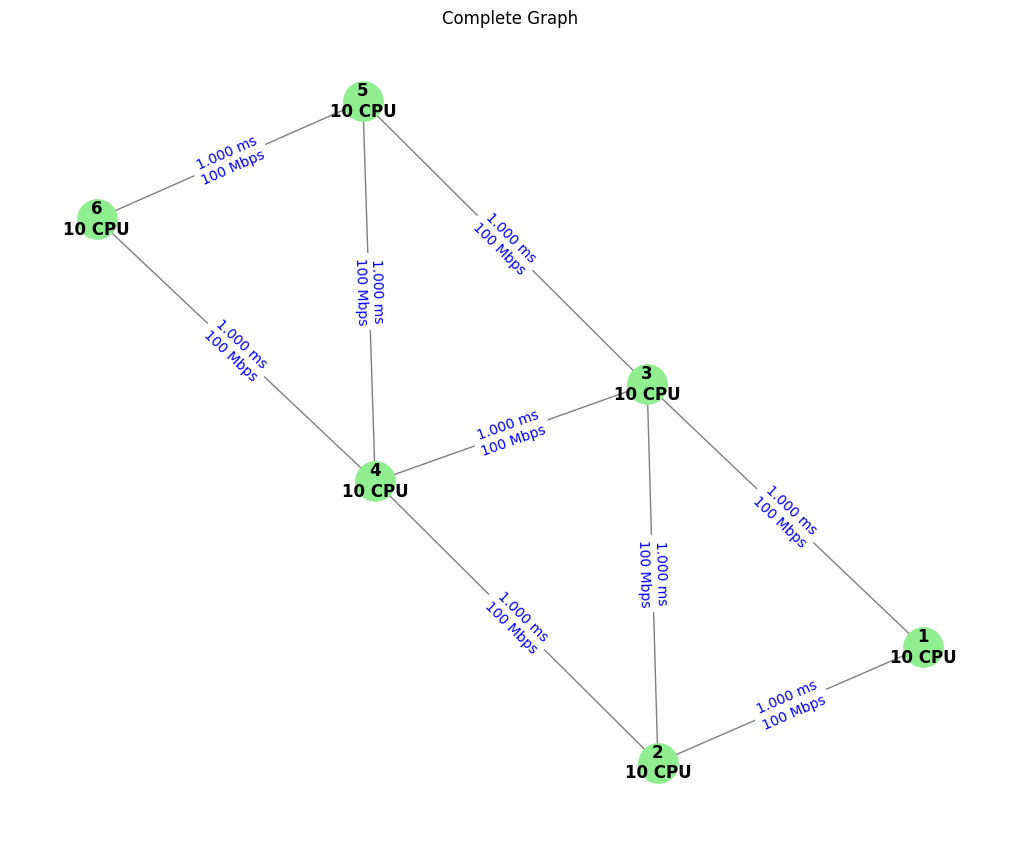

In [1]:
from topology import topology_bayern, draw_graph
from generate_slices import generate_random_slices
from milp.topology_to_instance import build_instance_from_topology
from milp.solver_scipy import solve_lp
import pandas as pd

G = topology_bayern()

draw_graph(G)


In [2]:
node_capacity_base = {n: G.nodes[n]["cpu"] for n in G.nodes}
link_capacity_base = {(u, v): G[u][v]["bandwidth"] for u, v in G.edges}
link_capacity_base.update({(v, u): G[u][v]["bandwidth"] for u, v in G.edges})
link_latency = {(u, v): G[u][v]["latency"] for u, v in G.edges}
link_latency.update({(v, u): G[u][v]["latency"] for u, v in G.edges})



In [3]:
vnf_profiles = [
    {"cpu": 2, "throughput": 50, "latency": 50},
    {"cpu": 4, "throughput": 60, "latency": 80},
    {"cpu": 6, "throughput": 70, "latency": 100}
]

# Example: generate 3 slices, each with 2 VNFs
slices = generate_random_slices(G, vnf_profiles, num_slices=3, num_vnfs_per_slice=2)

slices


[([{'id': 'vnf0_0', 'cpu': 2, 'throughput': 50, 'latency': 50, 'slice': 0},
   {'id': 'vnf0_1', 'cpu': 6, 'throughput': 70, 'latency': 100, 'slice': 0}],
  [{'from': 'vnf0_0', 'to': 'vnf0_1', 'bandwidth': 50, 'latency': 50}]),
 ([{'id': 'vnf1_0', 'cpu': 2, 'throughput': 50, 'latency': 50, 'slice': 1},
   {'id': 'vnf1_1', 'cpu': 2, 'throughput': 50, 'latency': 50, 'slice': 1}],
  [{'from': 'vnf1_0', 'to': 'vnf1_1', 'bandwidth': 50, 'latency': 50}]),
 ([{'id': 'vnf2_0', 'cpu': 2, 'throughput': 50, 'latency': 50, 'slice': 2},
   {'id': 'vnf2_1', 'cpu': 4, 'throughput': 60, 'latency': 80, 'slice': 2}],
  [{'from': 'vnf2_0', 'to': 'vnf2_1', 'bandwidth': 50, 'latency': 50}])]

In [4]:
from milp.formulation import MILPInstance
from milp.solver_scipy import solve_lp


def build_instance_from_topology(G, slices):
    return MILPInstance(G, slices)


instance = build_instance_from_topology(G, slices)
res, var_index = solve_lp(instance)

print("Objective value:", res.fun)
for name, idx in var_index.items():
    if res.x[idx] > 1e-6:
        print(name, res.x[idx])


Objective value: 3.5999999999999996
('v', 'vnf0_0', 6) 1.0
('v', 'vnf0_1', 4) 1.0
('v', 'vnf1_0', 6) 1.0
('v', 'vnf1_1', 3) 1.0
('v', 'vnf2_0', 1) 1.0
('v', 'vnf2_1', 4) 1.0
('u', 1) 0.2
('z', 1) 0.2
('u', 3) 0.2
('z', 3) 0.2
('u', 4) 1.0
('z', 4) 1.0
('u', 6) 0.4
('z', 6) 0.4


In [5]:
# All comments in English
import matplotlib.pyplot as plt
import networkx as nx

def plot_solution(G, res, var_index, instance):
    pos = nx.spring_layout(G, seed=42)

    # Collect VNFs per node
    vnfs_per_node = {n: [] for n in instance.N}
    active_nodes = set()
    for key, idx in var_index.items():
        if key[0] == "v" and res.x[idx] > 0.5:
            _, vnf, n = key
            vnfs_per_node[n].append(vnf)
        if key[0] == "z" and res.x[idx] > 0.5:
            _, n = key
            active_nodes.add(n)

    # Node colors: green if active, gray otherwise
    node_colors = []
    for n in G.nodes():
        node_colors.append("lightgreen" if n in active_nodes else "lightgray")

    # Draw base graph
    nx.draw(G, pos, node_color=node_colors, node_size=800, with_labels=False)

    # Labels = node id + VNFs
    labels = {}
    for n in G.nodes():
        if vnfs_per_node[n]:
            labels[n] = f"{n}\n" + ",".join(vnfs_per_node[n])
        else:
            labels[n] = str(n)

    nx.draw_networkx_labels(G, pos, labels, font_size=8)

    # Highlight active links
    active_edges = []
    for key, idx in var_index.items():
        if key[0] == "w" and res.x[idx] > 0.5:
            _, e = key
            active_edges.append(e)
    nx.draw_networkx_edges(G, pos, edgelist=active_edges, edge_color="red", width=2)

    plt.show()


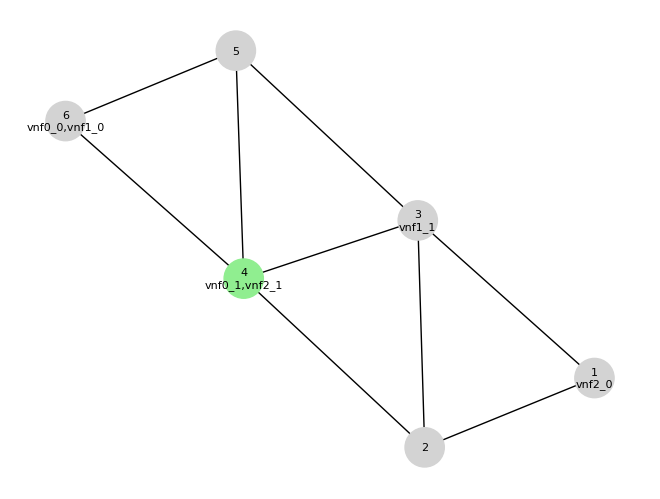

In [6]:
instance = build_instance_from_topology(G, slices)
res, var_index = solve_lp(instance)

plot_solution(G, res, var_index, instance)

In [7]:
from a_star import run_astar
from run_abo_full_batch import run_abo_full_batch
from run_fabo_full_batch import run_fabo_full_batch
from first_fit import run_first_fit
from best_fit import run_best_fit
from copy import deepcopy

In [8]:

df_astar, results_astar = run_astar(G, slices, node_capacity_base, link_capacity_base)
df_abo, abo_results = run_abo_full_batch(G, slices, node_capacity_base, link_latency ,link_capacity_base)
df_fabo, fabo_results = run_fabo_full_batch(G, slices, node_capacity_base, link_latency, link_capacity_base)
df_ff, ff_results = run_first_fit(G, slices, node_capacity_base, link_capacity_base, link_latency)
df_bestfit, bestfit_results = run_best_fit(G, slices, node_capacity_base, link_capacity_base, link_latency)


df_astar
df_abo
df_fabo
df_bestfit


[INFO][A*] === Solving slice 1 with 2 VNFs and 1 VLs ===
[INFO][A*] Placed vnf0_0 on node 1 (use=2, remaining=8).
[INFO][A*] Placed vnf0_0 on node 2 (use=2, remaining=8).
[INFO][A*] Placed vnf0_0 on node 3 (use=2, remaining=8).
[INFO][A*] Placed vnf0_0 on node 4 (use=2, remaining=8).
[INFO][A*] Placed vnf0_0 on node 5 (use=2, remaining=8).
[INFO][A*] Placed vnf0_0 on node 6 (use=2, remaining=8).
[INFO][A*] Placed vnf0_1 on node 2 (use=6, remaining=4).
[INFO][A*] Placed vnf0_1 on node 3 (use=6, remaining=4).
[INFO][A*] Placed vnf0_1 on node 4 (use=6, remaining=4).
[INFO][A*] Placed vnf0_1 on node 5 (use=6, remaining=4).
[INFO][A*] Placed vnf0_1 on node 6 (use=6, remaining=4).
[DEBUG][A*] Anti-affinity: vnf0_1 cannot be placed on node 1 (another VNF of slice 0 already there).
[INFO][A*] Placed vnf0_1 on node 1 (use=6, remaining=4).
[INFO][A*] Placed vnf0_1 on node 3 (use=6, remaining=4).
[INFO][A*] Placed vnf0_1 on node 4 (use=6, remaining=4).
[INFO][A*] Placed vnf0_1 on node 5 (use=6, 

,slice,accepted,g_cost
0,1,True,1
1,2,True,1
2,3,True,1


In [9]:
from compute_energy import (
    compute_energy_per_node,
    compute_total_bandwidth,
    compute_total_latency,
    compute_energy_per_slice,
    compute_total_energy_with_routing,
    compute_energy_new
)

def extract_milp_metrics(res, var_index, instance, G,
                         slices, node_capacity_base, link_capacity_base, link_latency):
    placed_vnfs = {}
    for i in instance.CPU_i:
        for n in instance.N:
            if res.x[var_index.get(("v", i, n), 0)] > 0.5:
                placed_vnfs[i] = n

    # Reconstruir caminhos (aqui simplificado: inclui arestas usadas pelo fluxo)
    routed_vls = {}
    for s in instance.S:
        vnf_ids = instance.V_of_s[s]
        for q in range(len(vnf_ids) - 1):
            i, j = vnf_ids[q], vnf_ids[q+1]
            path_links = [e for e in instance.E if res.x[var_index.get(("f", e, s, (i,j)), 0)] > 0.5]
            if path_links:
                routed_vls[(i,j)] = path_links

    # Montar capacidades residuais (igual heurísticas)
    node_capacity = {n: node_capacity_base[n] for n in G.nodes}
    link_capacity = {e: link_capacity_base[e] for e in G.edges}

    # FakeState compatível com compute_*
    class FakeState:
        def __init__(self, placed_vnfs, routed_vls, node_capacity, link_capacity):
            self.placed_vnfs = placed_vnfs
            self.routed_vls = routed_vls
            self.node_capacity = node_capacity
            self.link_capacity = link_capacity

    fake_state = FakeState(placed_vnfs, routed_vls, node_capacity, link_capacity)
    result_list = [fake_state]

    # Reusar os compute_* já existentes
    energy_per_slice, _ = compute_energy_per_slice(result_list, slices, node_capacity_base)
    _, total_energy_nodes = compute_energy_per_node(result_list, slices, node_capacity_base)
    total_bw_list = compute_total_bandwidth(result_list, slices)
    total_lat_list = compute_total_latency(result_list, link_latency)
    total_energy_with_routing = sum(
        compute_total_energy_with_routing(r, slices, node_capacity_base, G)
        for r in result_list if r is not None
    )
    total_energy_new = compute_energy_new(result_list, slices, node_capacity_base, link_capacity_base)

    return {
        "Method": "MILP",
        "Slices Accepted": sum(1 for e in energy_per_slice if e is not None),
        "CPU Utilized": sum(node_capacity_base.values()) - sum(fake_state.node_capacity.values()),
        "Total Bandwidth": sum(b for b in total_bw_list if b is not None),
        "Total Latency": sum(l for l in total_lat_list if l is not None),
        "Total Energy": total_energy_new,
        "Energy with Routing": total_energy_with_routing
    }





In [10]:
def count_slices_accepted(result_list, slices):
    accepted = 0
    for slice_idx, (vnfs, vls) in enumerate(slices):
        result = result_list[slice_idx] if slice_idx < len(result_list) else None
        if not result:
            continue

        ok = True
       
        vnf_ids = [vnf["id"] for vnf in vnfs]
        for vid in vnf_ids:
            if vid not in result.placed_vnfs:
                ok = False
                break

        if ok:
            for vl in vls:
                i, j = vl["from"], vl["to"]
                if (i, j) not in result.routed_vls:
                    ok = False
                    break

        if ok:
            accepted += 1
    return accepted


In [11]:
from compute_energy import (
    compute_energy_per_node,
    compute_total_bandwidth,
    compute_total_latency,
    compute_energy_per_slice,
    compute_total_energy_with_routing,
    compute_energy_new
)

method_results = {
    "A*": results_astar,
    "ABO": abo_results,
    "FABO": fabo_results,
    "First Fit": ff_results,
    "Best-fit": bestfit_results
}



In [12]:
comparison_rows = []  

# === Loop das heurísticas ===
for method_name, result_list in method_results.items():
    if not result_list:
        continue

    energy_per_slice, _ = compute_energy_per_slice(result_list, slices, node_capacity_base)
    _, total_energy = compute_energy_per_node(result_list, slices, node_capacity_base)

    total_bw_list = compute_total_bandwidth(result_list, slices)
    total_lat_list = compute_total_latency(result_list, link_latency)
    sum_bw  = sum(b for b in total_bw_list if b is not None)
    sum_lat = sum(l for l in total_lat_list if l is not None)

    normalized_energy = compute_energy_new(
        result_list, slices, node_capacity_base, link_capacity_base
    )

    # usa a nova função
    slices_accepted = count_slices_accepted(result_list, slices)

    comparison_rows.append({
        "Method": method_name,
        "Slices Accepted": slices_accepted,
        "Total Bandwidth": sum_bw,
        "Total Latency": sum_lat,
        "Total Energy": normalized_energy
    })

# === Adiciona o MILP manualmente ===
milp_metrics = extract_milp_metrics(
    res, var_index, instance, G,
    slices,                 
    node_capacity_base,     
    link_capacity_base,     
    link_latency            
)

comparison_rows.append({
    "Method": milp_metrics["Method"],
    "Slices Accepted": milp_metrics["Slices Accepted"],
    "Total Bandwidth": milp_metrics["Total Bandwidth"],
    "Total Latency": milp_metrics["Total Latency"],
    "Total Energy": milp_metrics["Total Energy"]
})

# === DataFrame final ===
df_metrics = pd.DataFrame(comparison_rows).reset_index(drop=True)
display(df_metrics)


,Method,Slices Accepted,Total Bandwidth,Total Latency,Total Energy
0,A*,3,150,3,7.8
1,ABO,3,150,3,4.8
2,FABO,3,150,3,7.8
3,First Fit,3,150,3,4.8
4,Best-fit,3,150,3,3.8
5,MILP,1,0,0,5.8


,Method,Slices Accepted,Total Slices,Acceptance Rate,Total CPU utilized
0,A*,3,3,1.0,18
1,ABO,3,3,1.0,18
2,FABO,3,3,1.0,18
3,First Fit,3,3,1.0,18
4,Best Fit,3,3,1.0,18
5,MILP,0,3,0.0,18


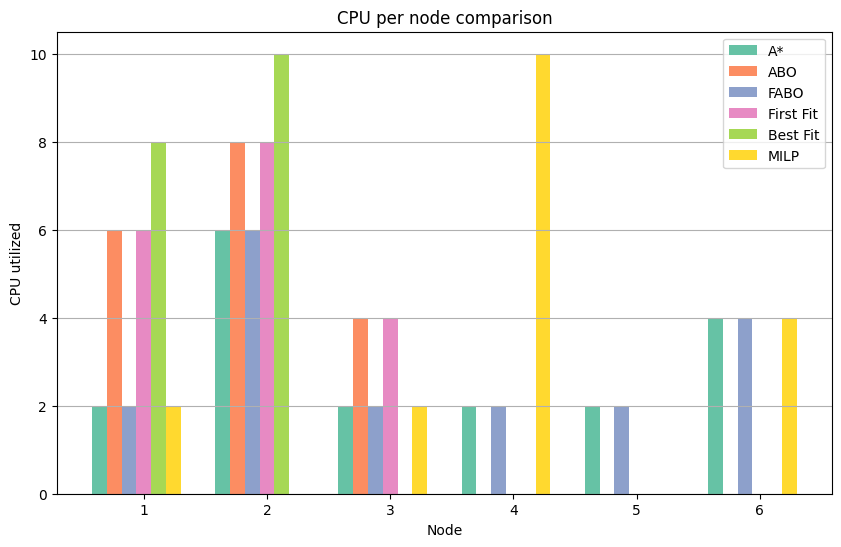

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Define node capacity for visualization
node_capacity = {n: G.nodes[n]["cpu"] for n in G.nodes}

# ----------------- PROCESS HEURISTICS -----------------
def process_results(results, method_name, slices):
    used_node_capacity = {n: 0 for n in G.nodes}
    accepted_slices = 0
    cpu_total_used = 0
    per_node_details = {n: [] for n in G.nodes}

    for slice_idx, result in enumerate(results):
        if not result:
            continue

        vnfs, vls = slices[slice_idx]
        vnf_cpu_map = {vnf["id"]: vnf["cpu"] for vnf in vnfs}

        ok = True
        # 1. Todos VNFs devem estar alocados
        for vnf in vnfs:
            if vnf["id"] not in result.placed_vnfs:
                ok = False
                break

        # 2. Todos VLs devem estar roteados
        if ok:
            for vl in vls:
                if (vl["from"], vl["to"]) not in result.routed_vls:
                    ok = False
                    break

        if ok:
            accepted_slices += 1
            # Só acumula CPU se o slice foi aceito
            for vnf_id, node in result.placed_vnfs.items():
                vnf_cpu = vnf_cpu_map[vnf_id]
                used_node_capacity[node] += vnf_cpu
                cpu_total_used += vnf_cpu
                per_node_details[node].append(vnf_id)

    total = len(results) if results else 1  

    return {
        "method": method_name,
        "accepted": accepted_slices,
        "total": len(results),
        "rate": accepted_slices / total,
        "cpu": cpu_total_used,
        "usage": used_node_capacity,
        "vnfs": per_node_details
    }

# ----------------- PROCESS MILP -----------------
def process_milp_solution(res, var_index, instance, slices, method_name="MILP"):
    used_node_capacity = {n: 0 for n in instance.N}
    per_node_details = {n: [] for n in instance.N}
    cpu_total_used = 0
    accepted_slices = 0

    for s in instance.S:
        vnfs, vls = slices[s]
        ok = True

        # 1. VNFs alocados
        for v in vnfs:
            i = v["id"]
            assigned_nodes = [n for n in instance.N if res.x[var_index.get(("v", i, n), 0)] > 0.5]
            if assigned_nodes:
                n = assigned_nodes[0]
                vnf_cpu = instance.CPU_i[i]
                used_node_capacity[n] += vnf_cpu
                cpu_total_used += vnf_cpu
                per_node_details[n].append(i)
            else:
                ok = False
                break

        # 2. VLs roteados
        if ok:
            for vl in vls:
                i, j = vl["from"], vl["to"]
                if not any(res.x[var_index.get(("f", e, s, (i,j)), 0)] > 0.5 for e in instance.E):
                    ok = False
                    break

        if ok:
            accepted_slices += 1

    return {
        "method": method_name,
        "accepted": accepted_slices,
        "total": len(instance.S),
        "rate": accepted_slices / len(instance.S),
        "cpu": cpu_total_used,
        "usage": used_node_capacity,
        "vnfs": per_node_details
    }

# ----------------- COLLECT ALL METHODS -----------------
methods_data = []
if 'results_astar' in globals():
    methods_data.append(process_results(results_astar, "A*", slices))
if 'abo_results' in globals():
    methods_data.append(process_results(abo_results, "ABO", slices))
if 'fabo_results' in globals():
    methods_data.append(process_results(fabo_results, "FABO", slices))
if 'ff_results' in globals():
    methods_data.append(process_results(ff_results, "First Fit", slices))
if 'bestfit_results' in globals():
    methods_data.append(process_results(bestfit_results, "Best Fit", slices))
if 'res' in globals() and 'var_index' in globals() and 'instance' in globals():
    methods_data.append(process_milp_solution(res, var_index, instance, slices, "MILP"))

# ----------------- CHECK FOR OVERCAPACITY -----------------
for method in methods_data:
    for node, cpu_used in method["usage"].items():
        if cpu_used > node_capacity[node]:
            print(f"[ALERT] Overcapacity in {method['method']} on node {node}: "
                  f"{cpu_used} > {node_capacity[node]}")

# ----------------- SUMMARY TABLE -----------------
summary_table = pd.DataFrame([
    {
        "Method": data["method"],
        "Slices Accepted": data["accepted"],
        "Total Slices": data["total"],
        "Acceptance Rate": round(data["rate"], 2),
        "Total CPU utilized": data["cpu"]
    }
    for data in methods_data
])
display(summary_table)

# ----------------- PLOT COMPARISON -----------------
fig, ax = plt.subplots(figsize=(10, 6))
nodes = list(node_capacity.keys())
bar_width = 0.12

colors = plt.cm.Set2.colors  # paleta automática
for idx, data in enumerate(methods_data):
    usage = [data["usage"].get(n, 0) for n in nodes]
    positions = [n + (idx - len(methods_data)/2) * bar_width for n in nodes]
    ax.bar(positions, usage, width=bar_width, label=data["method"], color=colors[idx % len(colors)])

ax.set_title("CPU per node comparison")
ax.set_xlabel("Node")
ax.set_ylabel("CPU utilized")
ax.set_xticks(nodes)
ax.legend()
plt.grid(axis='y')
plt.show()
